In [9]:
import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd
import matplotlib.pyplot as plt
from lxml import etree
import recordlinkage
import duckdb
import hashlib
from pathlib import Path
kagglehub.login

<function kagglehub.auth.login(validate_credentials: bool = True) -> None>

## **Loading Datasets**

We will be using two datasets found on Kaggle for this course project:
Global Earthquake-Tsunami Risk Assessment Dataset by Ahmed Mohamed Zaki
Climate Change: Earth Surface Temperature Data by Berkeley Earth and Kristen Sissener

In [10]:
# Download the datasets using methods specified on Kaggle
## Climate Dataset

path_climate = kagglehub.dataset_download(
    "berkeleyearth/climate-change-earth-surface-temperature-data"
)

print("Path to dataset files:", path_climate)


df_climate = pd.read_csv(path_climate + "/GlobalLandTemperaturesByMajorCity.csv")
df_climate.head()

Path to dataset files: C:\Users\qrama\.cache\kagglehub\datasets\berkeleyearth\climate-change-earth-surface-temperature-data\versions\2


,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1849-01-01,26.704,1.435,Abidjan,Côte D'Ivoire,5.63N,3.23W
1,1849-02-01,27.434,1.362,Abidjan,Côte D'Ivoire,5.63N,3.23W
2,1849-03-01,28.101,1.612,Abidjan,Côte D'Ivoire,5.63N,3.23W
3,1849-04-01,26.140,1.387,Abidjan,Côte D'Ivoire,5.63N,3.23W
4,1849-05-01,25.427,1.200,Abidjan,Côte D'Ivoire,5.63N,3.23W


In [11]:
## Earthquake Dataset
path_earthquake = kagglehub.dataset_download(
    "ahmeduzaki/global-earthquake-tsunami-risk-assessment-dataset"
)
print("Earthquake path:", path_earthquake)

df_earthquake = pd.read_csv(path_earthquake + "/earthquake_data_tsunami.csv")
df_earthquake.head()

Earthquake path: C:\Users\qrama\.cache\kagglehub\datasets\ahmeduzaki\global-earthquake-tsunami-risk-assessment-dataset\versions\1


,magnitude,cdi,mmi,sig,nst,dmin,gap,depth,latitude,longitude,Year,Month,tsunami
0,7.0,8,7,768,117,0.509,17.0,14.000,-9.7963,159.596,2022,11,1
1,6.9,4,4,735,99,2.229,34.0,25.000,-4.9559,100.738,2022,11,0
2,7.0,3,3,755,147,3.125,18.0,579.000,-20.0508,-178.346,2022,11,1
3,7.3,5,5,833,149,1.865,21.0,37.000,-19.2918,-172.129,2022,11,1
4,6.6,0,2,670,131,4.998,27.0,624.464,-25.5948,178.278,2022,11,1


From the demonstration of two datasets, we found that one common element that appear in both datasets is latitude & longitude. However, the format are slightly different in the two, as Climate dataset use directions, while Earthquake dataset use positive & negative numbers. In order to synthesize the dataset based on latitude and longitude, we need to uniform the format using *openRefine*.

## **Checking Hash Values**

In [12]:
# Function help caculate SHA Hash values

def sha256sum(file_path):

    h = hashlib.sha256()
    with open(file_path, "rb") as f:
        for chunk in iter(lambda: f.read(4096), b""):
            h.update(chunk)
    return h.hexdigest()

# Path of two datasets
climate_path = path_climate
earthquake_path = path_earthquake

# Calculate hashes
climate_hash = sha256sum(path_climate + "/GlobalLandTemperaturesByMajorCity.csv")
earthquake_hash = sha256sum(path_earthquake + "/earthquake_data_tsunami.csv")

print("SHA-256 Hashes:")
print(f"Climate dataset:    {climate_hash}")
print(f"Earthquake dataset: {earthquake_hash}")

SHA-256 Hashes:
Climate dataset:    11cb36d674d44d9286fb6924d2d0e3f7c19313ab8acdb76d3a55a8be5ddc0b0f
Earthquake dataset: 9cc6cbc0445f1b14d036432a978a97c3c89930c0a0023655e8f262e5eb3ae23d


## **Cleaned Data Inspection**

* First, we removed rows in Climate dataset with record year earlier than 2000, since those data cannot match any records in the earthquake dataset and therefore could not be used when analyzing pattern and would make merging messy.

* Second, we adjust the schema of latitude and longitude in Climate dataset, as they are currently in a format of (10N, 10W). We need to uniform the two datasets therefore we are changing its format to (10, -10), using positive to represent (North, East) and negative to represent (South, West).

* Lastly, we join the latitude and longitude columns in the two datasets for easier comparison and analysis.

In [28]:
df_climate_cleaned = pd.read_csv("GlobalLandTemperaturesByMajorCity-cleaned.csv")
df_climate_cleaned.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Latitude,Longitude
0,1993-11,27.210,0.245,Abidjan,5.63,-3.23
1,1993-12,26.996,0.277,Abidjan,5.63,-3.23
2,1994-01,27.014,0.295,Abidjan,5.63,-3.23
3,1994-02,28.687,0.466,Abidjan,5.63,-3.23
4,1994-03,28.571,0.214,Abidjan,5.63,-3.23


In [29]:
df_earthquake_cleaned = pd.read_csv("earthquake-data-tsunami-cleaned.csv")
df_earthquake_cleaned.head()

,magnitude,cdi,mmi,sig,nst,dmin,gap,depth,dt,tsunami,Latitude,Longitude
0,7.0,8,7,768,117,0.509,17.0,14.000,2022-11,1,-9.7963,159.596
1,6.9,4,4,735,99,2.229,34.0,25.000,2022-11,0,-4.9559,100.738
2,7.0,3,3,755,147,3.125,18.0,579.000,2022-11,1,-20.0508,-178.346
3,7.3,5,5,833,149,1.865,21.0,37.000,2022-11,1,-19.2918,-172.129
4,6.6,0,2,670,131,4.998,27.0,624.464,2022-11,1,-25.5948,178.278


## **Parse Dates + Create Year Columns**

Convert dt into real datetime objects and extract the year for both datasets.

In [41]:
# climate (dt like "1993-11")
df_climate_cleaned["dt"] = pd.to_datetime(
    df_climate_cleaned["dt"], format="%Y-%m", errors="coerce"
)
df_climate_cleaned["year"] = df_climate_cleaned["dt"].dt.year

# earthquake (dt like "2022-11")
df_earthquake_cleaned["dt"] = pd.to_datetime(
    df_earthquake_cleaned["dt"], format="%Y-%m", errors="coerce"
)
df_earthquake_cleaned["year"] = df_earthquake_cleaned["dt"].dt.year

## **Global Yearly Aggregates**

Aggregate earthquakes & climate data per year.

In [45]:
# Yearly earthquake summary
eq_yearly = (
    df_earthquake_cleaned
    .dropna(subset=["magnitude", "depth", "year"])
    .groupby("year")
    .agg(
        eq_count=("magnitude", "size"),
        avg_mag=("magnitude", "mean"),
        avg_depth=("depth", "mean"),
        tsunami_count=("tsunami", "sum")
    )
    .reset_index()
    .sort_values("year")
)
display(eq_yearly.head())

,year,eq_count,avg_mag,avg_depth,tsunami_count
0,2001,28,7.028571,40.564214,0
1,2002,25,6.900000,37.460000,0
2,2003,31,6.889032,34.418774,0
3,2004,32,6.959375,41.978125,0
4,2005,28,6.942857,76.096429,0


In [46]:
# Yearly climate summary
climate_yearly = (
    df_climate_cleaned
    .dropna(subset=["AverageTemperature", "year"])
    .groupby("year")
    .agg(
        avg_temp=("AverageTemperature", "mean"),
        avg_temp_uncertainty=("AverageTemperatureUncertainty", "mean")
    )
    .reset_index()
    .sort_values("year")
)

display(climate_yearly.head())

,year,avg_temp,avg_temp_uncertainty
0,1993,15.000095,0.402225
1,1994,19.472903,0.348477
2,1995,19.439888,0.338968
3,1996,19.171847,0.330993
4,1997,19.350162,0.365349


## **Merge Global Yearly Tables**

Join climate + earthquake summaries.

In [47]:
merged_yearly = pd.merge(eq_yearly, climate_yearly, on="year", how="inner")
print("merged_yearly head:")
display(merged_yearly.head())

merged_yearly head:


,year,eq_count,avg_mag,avg_depth,tsunami_count,avg_temp,avg_temp_uncertainty
0,2001,28,7.028571,40.564214,0,19.679352,0.368197
1,2002,25,6.900000,37.460000,0,19.855685,0.363328
2,2003,31,6.889032,34.418774,0,19.630197,0.387107
3,2004,32,6.959375,41.978125,0,19.672204,0.357262
4,2005,28,6.942857,76.096429,0,19.607239,0.348205


## **Correlation With Global Temperature**

See how temp relates to earthquake metrics.

In [48]:
corr_with_temp = merged_yearly[
    ["eq_count", "avg_mag", "avg_depth", "tsunami_count"]
].corrwith(merged_yearly["avg_temp"])

print("Correlation with avg_temp:")
print(corr_with_temp)


Correlation with avg_temp:
eq_count         0.713930
avg_mag         -0.065750
avg_depth        0.525782
tsunami_count    0.792007
dtype: float64


## **Global Plots**

Join climate + earthquake summaries.

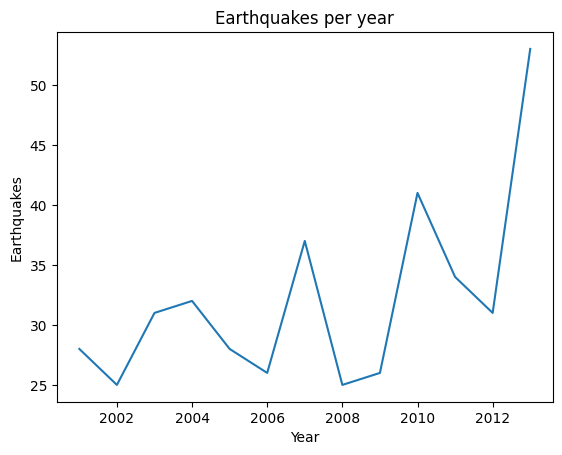

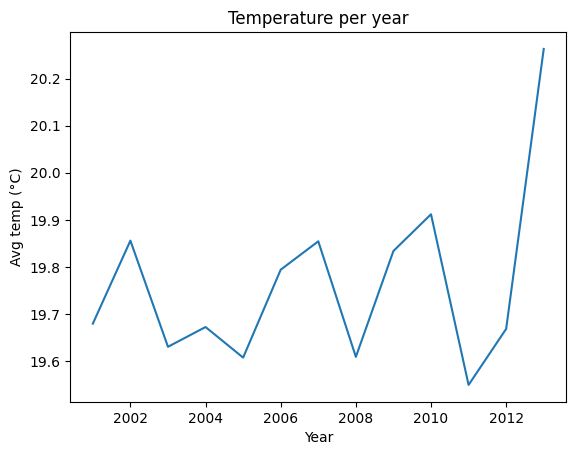

In [49]:
plt.plot(merged_yearly["year"], merged_yearly["eq_count"])
plt.xlabel("Year"); plt.ylabel("Earthquakes"); plt.title("Earthquakes per year")
plt.show()

plt.plot(merged_yearly["year"], merged_yearly["avg_temp"])
plt.xlabel("Year"); plt.ylabel("Avg temp (°C)"); plt.title("Temperature per year")
plt.show()


## **Region Bins (10-degree latitude/longitude bins)**

Geographic structure

In [50]:
def add_region(df):
    df["lat_bin"] = (df["Latitude"] // 10 * 10).astype(int)
    df["lon_bin"] = (df["Longitude"] // 10 * 10).astype(int)
    df["region"] = df["lat_bin"].astype(str) + "_" + df["lon_bin"].astype(str)
    return df

clim_reg = add_region(df_climate_cleaned.copy())
eq_reg = add_region(df_earthquake_cleaned.copy())

display(clim_reg.head())
display(eq_reg.head())


,dt,AverageTemperature,AverageTemperatureUncertainty,City,Latitude,Longitude,year,lat_bin,lon_bin,region
0,1993-11-01,27.210,0.245,Abidjan,5.63,-3.23,1993,0,-10,0_-10
1,1993-12-01,26.996,0.277,Abidjan,5.63,-3.23,1993,0,-10,0_-10
2,1994-01-01,27.014,0.295,Abidjan,5.63,-3.23,1994,0,-10,0_-10
3,1994-02-01,28.687,0.466,Abidjan,5.63,-3.23,1994,0,-10,0_-10
4,1994-03-01,28.571,0.214,Abidjan,5.63,-3.23,1994,0,-10,0_-10


,magnitude,cdi,mmi,sig,nst,dmin,gap,depth,dt,tsunami,Latitude,Longitude,year,lat_bin,lon_bin,region
0,7.0,8,7,768,117,0.509,17.0,14.000,2022-11-01,1,-9.7963,159.596,2022,-10,150,-10_150
1,6.9,4,4,735,99,2.229,34.0,25.000,2022-11-01,0,-4.9559,100.738,2022,-10,100,-10_100
2,7.0,3,3,755,147,3.125,18.0,579.000,2022-11-01,1,-20.0508,-178.346,2022,-30,-180,-30_-180
3,7.3,5,5,833,149,1.865,21.0,37.000,2022-11-01,1,-19.2918,-172.129,2022,-20,-180,-20_-180
4,6.6,0,2,670,131,4.998,27.0,624.464,2022-11-01,1,-25.5948,178.278,2022,-30,170,-30_170


## **Regional Aggregates**

Summarize by region

In [ ]:
# Climate regional summary
climate_reg = (
    clim_reg
    .dropna(subset=["AverageTemperature", "year"])
    .groupby(["year", "region"])
    .agg(
        avg_temp=("AverageTemperature", "mean"),
        avg_temp_uncertainty=("AverageTemperatureUncertainty", "mean"),
        n_temp_obs=("AverageTemperature", "size")
    )
    .## **Regional Aggregates**
Summarize by region
# Climate regional summary
climate_reg = (
    clim_reg
    .dropna(subset=["AverageTemperature", "year"])
    .groupby(["year", "region"])
    .agg(
        avg_temp=("AverageTemperature", "mean"),
        avg_temp_uncertainty=("AverageTemperatureUncertainty", "mean"),
        n_temp_obs=("AverageTemperature", "size")
    )
    .reset_index()
)

# Earthquake regional summary ---
eq_reg_yearly = (
    eq_reg
    .dropna(subset=["magnitude", "depth", "year"])
    .groupby(["year", "region"])
    .agg(
        eq_count=("magnitude", "size"),
        avg_mag=("magnitude", "mean"),
        avg_depth=("depth", "mean"),
        tsunami_count=("tsunami", "sum")
    )
    .reset_index()
)

display(climate_reg.head())
display(eq_reg_yearly.head())
reset_index()
)

# Earthquake regional summary ---
eq_reg_yearly = (
    eq_reg
    .dropna(subset=["magnitude", "depth", "year"])
    .groupby(["year", "region"])
    .agg(
        eq_count=("magnitude", "size"),
        avg_mag=("magnitude", "mean"),
        avg_depth=("depth", "mean"),
        tsunami_count=("tsunami", "sum")
    )
    .reset_index()
)

display(climate_reg.head())
display(eq_reg_yearly.head())


,year,region,avg_temp,avg_temp_uncertainty,n_temp_obs
0,1993,-10_-50,29.40050,0.25050,2
1,1993,-10_10,24.87775,0.48725,4
2,1993,-10_100,26.83600,0.19400,2
3,1993,-10_110,28.53950,0.24950,2
4,1993,-10_30,22.14500,0.50025,4


,year,region,eq_count,avg_mag,avg_depth,tsunami_count
0,2001,-10_100,2,7.150000,32.0,0
1,2001,-10_120,2,7.000000,33.0,0
2,2001,-10_130,1,6.500000,33.0,0
3,2001,-10_150,3,6.833333,22.0,0
4,2001,-20_-80,4,7.325000,38.0,0


## **Merge Regional Data**

Create a combined regional dataset.

In [52]:
merged_regional = pd.merge(
    eq_reg_yearly,
    climate_reg,
    on=["year", "region"],
    how="inner"
)

print("merged_regional:", merged_regional.shape)
display(merged_regional.head())

merged_regional: (61, 9)


,year,region,eq_count,avg_mag,avg_depth,tsunami_count,avg_temp,avg_temp_uncertainty,n_temp_obs
0,2001,-10_100,2,7.150,32.0,0,27.132333,0.368750,12
1,2001,-20_-80,4,7.325,38.0,0,16.948667,0.534500,12
2,2001,20_120,1,6.800,14.0,0,23.153417,0.263333,12
3,2001,20_70,1,7.700,16.0,0,26.360972,0.402069,72
4,2001,30_130,1,6.800,50.0,0,14.299750,0.202000,24


## **Regional Correlations**

Filter out tiny regions and compute regional correlations.

In [ ]:
mr = merged_regional[merged_regional["n_temp_obs"] >= 6].copy()

regional_corr = mr[["eq_count", "avg_mag", "avg_depth"]].corrwith(mr["avg_temp"])
print("Regional correlation with avg_temp:")
print(regional_corr)

top_regions = (
    mr.groupby("region")
      .agg(
          mean_eq_count=("eq_count", "mean"),
          mean_temp=("avg_temp", "mean")
      )
      .sort_values("mean_eq_count", ascending=False)
      .head(10)
)

display(top_regions)


Regional correlation with avg_temp:
eq_count    -0.006128
avg_mag      0.026053
avg_depth   -0.098438
dtype: float64


,mean_eq_count,mean_temp
region,,
-10_100,2.600000,27.256883
20_60,2.000000,27.116854
30_130,2.000000,14.615400
-20_-80,1.500000,17.110715
-10_110,1.500000,27.586625
30_20,1.250000,18.505469
0_-80,1.250000,21.736271
30_70,1.200000,21.961594
20_120,1.142857,23.181464


## **DuckDB SQL Analysis**

To show advanced querying

In [56]:
con = duckdb.connect()
con.register("merged_yearly", merged_yearly)
con.register("merged_regional", merged_regional)

display(con.execute("""
    SELECT year, eq_count, avg_temp
    FROM merged_yearly
    ORDER BY eq_count DESC
    LIMIT 10;
""").df())

display(con.execute("""
    SELECT region,
           AVG(eq_count) AS mean_eq_count,
           AVG(avg_temp) AS mean_temp
    FROM merged_regional
    GROUP BY region
    ORDER BY mean_eq_count DESC
    LIMIT 10;
""").df())

display(con.execute("""
    SELECT (year/10)*10 AS decade,
           AVG(eq_count) AS mean_eq,
           AVG(avg_temp) AS mean_temp
    FROM merged_yearly
    GROUP BY decade
    ORDER BY decade;
""").df())

,year,eq_count,avg_temp
0,2013,53,20.263006
1,2010,41,19.911734
2,2007,37,19.854270
3,2011,34,19.549197
4,2004,32,19.672204
5,2012,31,19.668239
6,2003,31,19.630197
7,2005,28,19.607239
8,2001,28,19.679352
9,2009,26,19.833752


,region,mean_eq_count,mean_temp
0,-10_100,2.600000,27.256883
1,20_60,2.000000,27.116854
2,30_130,2.000000,14.615400
3,-20_-80,1.500000,17.110715
4,-10_110,1.500000,27.586625
5,30_20,1.250000,18.505469
6,0_-80,1.250000,21.736271
7,30_70,1.200000,21.961594
8,20_120,1.142857,23.181464
9,20_90,1.000000,26.043417


,decade,mean_eq,mean_temp
0,2001.0,28.0,19.679352
1,2002.0,25.0,19.855685
2,2003.0,31.0,19.630197
3,2004.0,32.0,19.672204
4,2005.0,28.0,19.607239
5,2006.0,26.0,19.793993
6,2007.0,37.0,19.854270
7,2008.0,25.0,19.608778
8,2009.0,26.0,19.833752
9,2010.0,41.0,19.911734
